In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/RL/GAIL

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RL/GAIL


In [ ]:
!pip install -r requirement.txt


     |████████████████████████████████| 14.5 MB 8.2 kB/s 
     |████████████████████████████████| 776.8 MB 17 kB/s 
     |████████████████████████████████| 10.3 MB 47.3 MB/s 
     |████████████████████████████████| 1.5 MB 45.4 MB/s 
     |████████████████████████████████| 448 kB 47.5 MB/s 
  Created wheel for gym: filename=gym-0.11.0-py3-none-any.whl size=1588477 sha256=93a78eb76de3c6b13f011d0102c4e36047bbaa4aec1f60111e584ac28aeefca5
  Stored in directory: /root/.cache/pip/wheels/7c/9e/4f/cb2e795b8075cfc206f4ad30e2be04cb03c3d52dfcc1306cfa
Successfully built gym
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.

# Algorithms Implementation

In [ ]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
from torch.autograd import Variable

label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

import torch.nn.functional as F

class ExpertTraj:
    """
    class holding the expert trajectories
    """
    def __init__(self, env_name):
        self.exp_states = np.loadtxt("./expert_traj/{}/{}_expert_states.dat".format(env_name, env_name))
        self.exp_actions = np.loadtxt("./expert_traj/{}/{}_expert_actions.dat".format(env_name, env_name))
        self.n_transitions = len(self.exp_actions)

    def sample(self, batch_size):
        indexes = np.random.randint(0, self.n_transitions, size=batch_size)
        state, action = [], []
        for i in indexes:
            s = self.exp_states[i]
            a = self.exp_actions[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
        return np.array(state), np.array(action)


class Actor(nn.Module):
    """
    Actor, policy function
    """
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)

        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = torch.tanh(self.l3(x)) * self.max_action
        return x


class Discriminator(nn.Module):
    """
    Discriminator, act like a value function
    """
    def __init__(self, state_dim, action_dim):
        super(Discriminator, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, state, action):
        state_action = torch.cat([state, action], 1)
        x = torch.tanh(self.l1(state_action))
        x = torch.tanh(self.l2(x))
        x = torch.sigmoid(self.l3(x))
        return x


class GAIL:

    def __init__(self, args, env_name, log_file):
        self.env = gym.make(args.env_name)
        state_dim = self.env.observation_space.shape[0]
        action_dim = self.env.action_space.shape[0]
        max_action = float(self.env.action_space.high[0])
        self.args = args
        self.device = args.device
        self.actor = Actor(state_dim, action_dim, max_action).to(self.device)
        self.optim_actor = torch.optim.Adam(self.actor.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.discriminator = Discriminator(state_dim, action_dim).to(self.device)
        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002,
                                                    betas=(0.5,0.999))
        self.max_action = max_action
        self.expert = ExpertTraj(env_name)
        self.loss_fn = nn.BCELoss()

        self.log_file = log_file
        self.rng = np.random.RandomState()

    def select_action(self, state):
        """
        actor selects the action
        :param state: game state
        :return: continuous actions
        """
        state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
        return self.actor(state).cpu().data.numpy().flatten()


    def plot(self, batch_nums, perf_nums, y_tag):
        """
        Draw the plot
        :param batch_nums: x-axis numbers
        :param perf_nums: y-axis numbers
        :param y_tag: y-axis description
        """
        plt.figure(figsize=(20,5))
        plt.xlabel('Training Step', fontsize=15)
        plt.ylabel(y_tag, fontsize=15)
        plt.plot(batch_nums, perf_nums)
        plt.savefig('gail_{0}.png'.format(y_tag))

    def test(self, max_timesteps=1500):
        """
        testing the actor
        :param max_timesteps: max testing step
        :return: total testing rewards
        """
        totalr = 0.
        state = self.env.reset()
        for t in range(max_timesteps):
            action = self.select_action(state)
            state, reward, done, _ = self.env.step(action)
            totalr += reward
            if done:
                break
        print('Total reward is {0}'.format(totalr), file=self.log_file, flush=True)
        return totalr

    def train(self, n_iter):
        """
        training GAIL
        :param n_iter: the number of training steps
        """

        d_running_loss = 0
        a_running_loss = 0
        training_rewards_record = []
        training_d_loss_record = []
        training_a_loss_record = []
        training_steps_record = []

        for train_step in range(n_iter+1):

            # sample expert transitions
            exp_state, exp_action = self.expert.sample(self.args.batch_size)
            exp_state = torch.FloatTensor(exp_state).to(self.device)
            exp_action = torch.FloatTensor(exp_action).to(self.device)

            # sample expert states for actor
            state, _ = self.expert.sample(self.args.batch_size)
            state = torch.FloatTensor(state).to(self.device)
            action = self.actor(state)

            #######################
            # update discriminator
            #######################
            self.optim_discriminator.zero_grad()
            
            # Getting the output of the descriminator
            real_prob = self.discriminator(exp_state, exp_action)
            fake_prob = self.discriminator(state, action.detach())
            prob = torch.cat((real_prob, fake_prob), dim=0).to(self.device)

            # Setting the label
            real_label = torch.ones(real_prob.shape)
            fake_label = torch.zeros(fake_prob.shape)
            label = torch.cat((real_label, fake_label), dim=0).to(self.device)

            # Calc. loss
            loss_discriminator = self.loss_fn(prob, label.detach())

            # back propagation
            loss_discriminator.backward()
            self.optim_discriminator.step()

            ################
            # update policy
            ################
            self.optim_actor.zero_grad()
            label = torch.zeros((self.args.batch_size, 1)).to(self.device)
            loss_actor = self.loss_fn(self.discriminator(state, action), label.detach()) * -1

            loss_actor.backward()
            self.optim_actor.step()

            d_running_loss += loss_discriminator.item()
            a_running_loss += loss_actor.mean().item()
            if train_step % 100 == 0:
                print('[%d] discriminator loss: %.6f, actor loss %.6f' % (train_step + 1,
                                                                          d_running_loss / (train_step + 1),
                                                                          a_running_loss / (train_step + 1)),
                      file=self.log_file, flush=True)
                totalr = self.test()
                training_rewards_record.append(totalr)
                training_steps_record.append(train_step)
                training_d_loss_record.append(loss_discriminator.item())
                training_a_loss_record.append(loss_actor.mean().item())

        avg_last_10_rewards = []
        for idx in range(len(training_rewards_record)):
            if idx >= 10:
                avg_last_10_rewards.append(np.mean(training_rewards_record[idx - 9:idx + 1]))
            else:
                avg_last_10_rewards.append(np.mean(training_rewards_record[:idx + 1]))

        self.plot(batch_nums=training_steps_record, perf_nums=avg_last_10_rewards, y_tag='Rewards')
        self.plot(batch_nums=training_steps_record, perf_nums=training_d_loss_record, y_tag='Discriminator_Loss')
        self.plot(batch_nums=training_steps_record, perf_nums=training_a_loss_record, y_tag='Actor_Loss')


class BehaviorCloning:

    def __init__(self, args, env_name, log_file):
        self.env = gym.make(args.env_name)
        state_dim = self.env.observation_space.shape[0]
        action_dim = self.env.action_space.shape[0]
        max_action = float(self.env.action_space.high[0])
        self.args = args
        self.device = args.device
        self.model = Actor(state_dim, action_dim, max_action).to(self.device)
        self.optim_actor = torch.optim.Adam(self.model.parameters(), lr=0.00003)

        self.log_file = log_file
        self.rng = np.random.RandomState()
        self.expert = ExpertTraj(env_name)

    def train(self, n_iter):
        """
        training Behavior Cloning
        :param n_iter: the number of training steps
        """
        criterion = nn.MSELoss()

        running_loss = 0
        training_rewards_record = []
        training_loss_record = []
        training_steps_record = []
        for train_step in (range(n_iter + 1)):
            exp_state, exp_action = self.expert.sample(self.args.batch_size)
            exp_state = torch.FloatTensor(exp_state).to(self.device)
            exp_action = torch.FloatTensor(exp_action).to(self.device)
            outputs = self.model(exp_state)
            loss = criterion(input=outputs, target=exp_action)
            self.optim_actor.zero_grad()
            loss.backward()
            self.optim_actor.step()
            running_loss += loss.item()
            if train_step % 100 == 0:
                print('[%d] loss: %.6f' % (train_step + 1, running_loss / (train_step + 1)), file=self.log_file,
                      flush=True)
                totalr = self.test()
                training_rewards_record.append(totalr)
                training_loss_record.append(loss.item())
                training_steps_record.append(train_step)
        avg_last_10_rewards = []
        for idx in range(len(training_rewards_record)):
            if idx >= 10:
                avg_last_10_rewards.append(np.mean(training_rewards_record[idx - 9:idx + 1]))
            else:
                avg_last_10_rewards.append(np.mean(training_rewards_record[:idx + 1]))

        self.plot(batch_nums=training_steps_record, perf_nums=avg_last_10_rewards, y_tag='Rewards')
        self.plot(batch_nums=training_steps_record, perf_nums=training_loss_record, y_tag='Loss')

    def select_action(self, state):
        """
        actor selects the action
        :param state: game state
        :return: continuous actions
        """
        state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
        return self.model(state).cpu().data.numpy().flatten()

    def plot(self, batch_nums, perf_nums, y_tag):
        """
        Draw the plot
        :param batch_nums: x-axis numbers
        :param perf_nums: y-axis numbers
        :param y_tag: y-axis description
        """
        plt.figure(figsize=(20,5))
        plt.xlabel('Training Step', fontsize=15)
        plt.ylabel(y_tag, fontsize=15)
        plt.plot(batch_nums, perf_nums)
        plt.savefig('behavior_cloning_{0}.png'.format(y_tag))

    def test(self, max_timesteps=1500):
        """
        testing the actor
        :param max_timesteps: max testing step
        :return: total testing rewards
        """
        totalr = 0.
        state = self.env.reset()
        for t in range(max_timesteps):
            action = self.select_action(state)
            state, reward, done, _ = self.env.step(action)
            totalr += reward
            if done:
                break
        print('Total reward is {0}'.format(totalr), file=self.log_file, flush=True)
        return totalr


def gail(args):
    """
    run GAIL
    :param args: parameters
    """
    if args.log_dir is not None:
        log_file = open(args.log_dir, 'w')
    else:
        log_file = None
    student = GAIL(args, args.env_name, log_file)
    student.train(n_iter=50000)


def behavior_cloning(args):
    """
    run behavior cloning
    :param args: parameters
    """
    if args.log_dir is not None:
        log_file = open(args.log_dir, 'w')
    else:
        log_file = None
    student = BehaviorCloning(args, args.env_name, log_file)
    student.train(n_iter=50000)

# Behavior Cloning

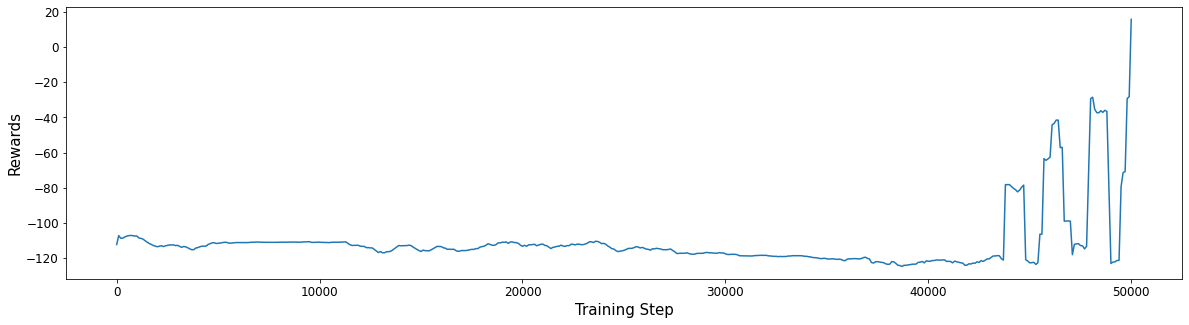

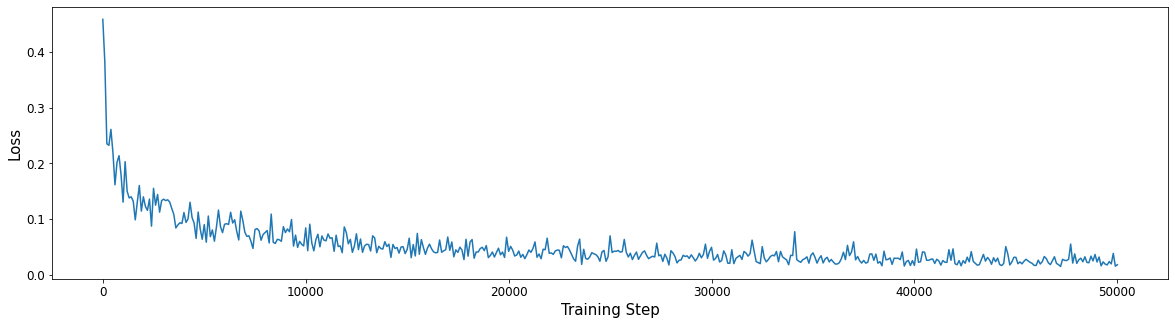

In [ ]:
def init_config():
    parser = argparse.ArgumentParser()
    parser.add_argument('-f')
    parser.add_argument('--log_dir', default='./log.txt', type=str, help='the log file')
    parser.add_argument('--mode',
                        choices=['cloning', 'gail'],
                        help='Learning mode',
                        default='cloning')
    parser.add_argument('--device',
                        choices=['cpu', 'cuda'],
                        default='cuda',
                        help='The name of device')
    parser.add_argument('--env_name', type=str, default='BipedalWalker-v2')
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--expert_model_path', type=str,
                        default='./expert_model/highway-DQN-expert-baselines-2021-03-14.pt')

    args = parser.parse_args()
    return args


def main():
    args = init_config()
    if args.mode == 'cloning':
        behavior_cloning(args)
    elif args.mode == 'gail':
        gail(args)
    else:
        raise ValueError("Unknown running mode: {0}".format(args.mode))


if __name__ == '__main__':
    main()


# GAIL

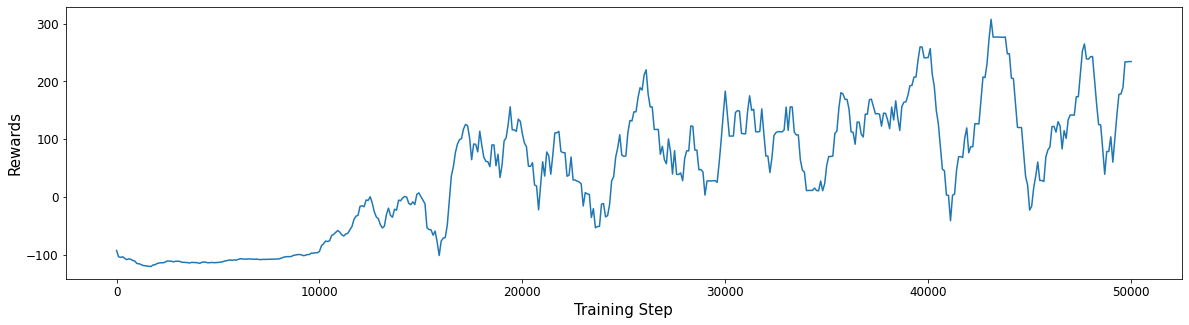

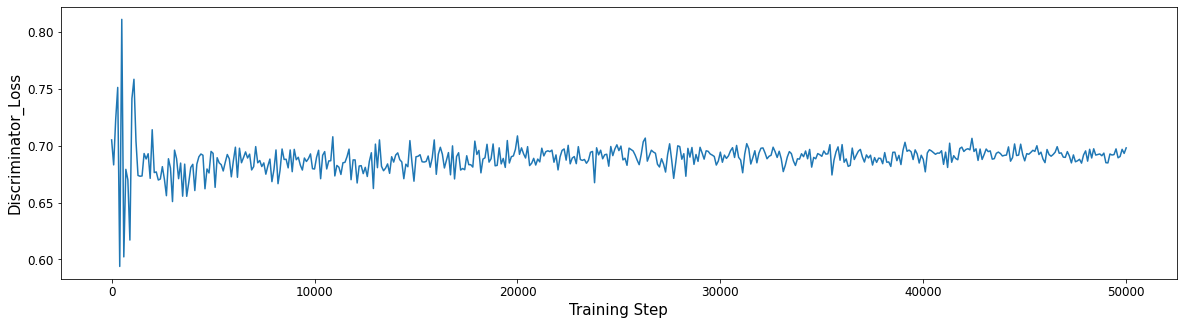

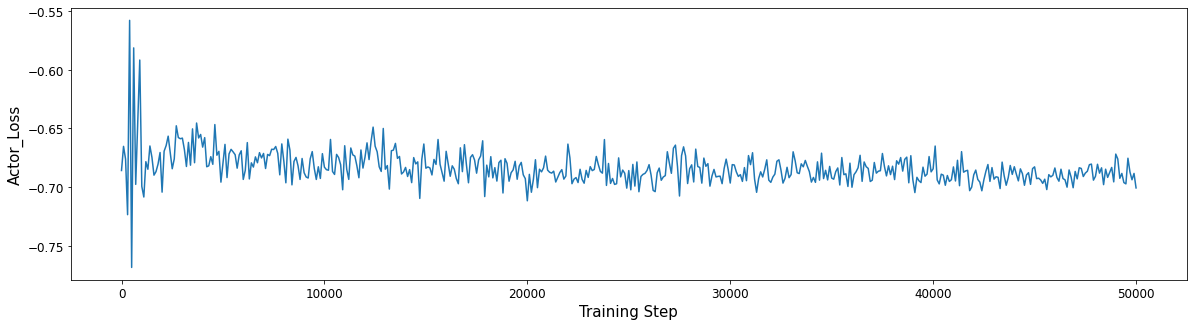

In [ ]:
def init_config():
    parser = argparse.ArgumentParser()
    parser.add_argument('-f')
    parser.add_argument('--log_dir', default='./log.txt', type=str, help='the log file')
    parser.add_argument('--mode',
                        choices=['cloning', 'gail'],
                        help='Learning mode',
                        default='gail')
    parser.add_argument('--device',
                        choices=['cpu', 'cuda'],
                        default='cuda',
                        help='The name of device')
    parser.add_argument('--env_name', type=str, default='BipedalWalker-v2')
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--expert_model_path', type=str,
                        default='./expert_model/highway-DQN-expert-baselines-2021-03-14.pt')

    args = parser.parse_args()
    return args


def main():
    args = init_config()
    if args.mode == 'cloning':
        behavior_cloning(args)
    elif args.mode == 'gail':
        gail(args)
    else:
        raise ValueError("Unknown running mode: {0}".format(args.mode))


if __name__ == '__main__':
    main()


# Comparision

Obviously, GAIL outperforms BC in terms of achieving higher and higher rewards in shorter time. 

There are a couple of reasons that can explain this:
- In GAIL, apart from the Actor network, we have the Discriminator network that represents the expert actions. Therefore, in a single epoch, GAIL exploits more information from the dataset for training Actor network(explicitly from the data set and also the Descriminator network). As a result, GAIL is more sample efficient, and can learn quite fast because of the Discrimator assistanc.
- BC tries to mimic the exact expert actions regardless of any relevent problem context. This method is prone to error since it only relies on what is apparent, however, there maybe some more complicated stuff behind the curtain which BC overlooks. In contrast, GAIL is an RL method. The ultimate goal is not to exactly mimic the expoert actions. We have two agents that are trying fool each other about those actions. It's true that at first they rely on the expert obseravtion, but they can go further and even outperfom the expert. Therefore, GAIL offers more generalizability! 

On the other hand, one can observe that the loss is generally decreasing in BC, however, in GAIL loss is oscillating around some value and does not vanish away. The reason is that in BC we are doing supervised-learning which its goal is to reduce the loss in each step, and here BC successfully accomplishes that. In contrast, in GAIL the definition of loss is totally different! Two agents in GAIL are learning together. The loss here means how many of the generator-crafted instances the descriminator can correctly detect as fake or real. Since both agents are learning together and become stronger and stronger, no one can beat the other, so the loss does not disappear.

**I also need to mention that I have doubled learning rate for this problem**